# Constraint Satisfaction Problem : Graph coloring


## Create Data

We can create a planar graph with $n$ vertices by randomly placing $n$ points in 2-dimensional Euclidean space and then performing a [Delaunay triangulation](https://en.wikipedia.org/wiki/Delaunay_triangulation).

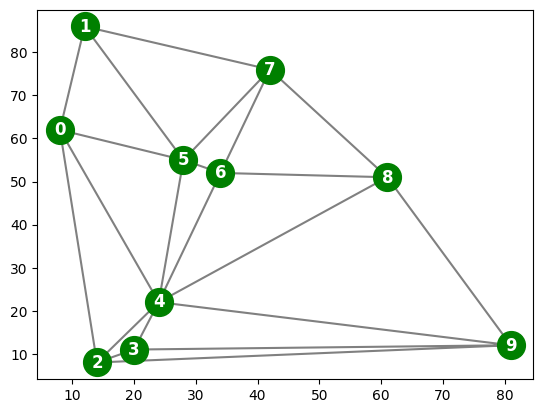

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

np.random.seed(1111)

# create points and sort them by
n = 10
points = np.random.randint(100, size=(n, 2))
o = np.argsort(points[:,0])
points = points[o,:]


# triangulate
tri = Delaunay(points)


# plot
plt.triplot(points[:,0], points[:,1], tri.simplices, color = "gray")
plt.plot(points[:,0], points[:,1], 'o', color = "green", markersize = 20)

for i in range(len(points)):
       plt.annotate(i, points[i,:],
        color='white', fontsize="large", weight='heavy',
        horizontalalignment='center', verticalalignment='center')

plt.show()

The triangulation can be converted into a list with an array of neighbor vertex indices for each point (see man page for [scipy.spatial.Delaunay](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Delaunay.html)).

In [2]:
(indptr, indices) = tri.vertex_neighbor_vertices

neighbors = []

for k in range(len(indptr)-1):
    neighbors.append(np.sort(indices[indptr[k]:indptr[k+1]]))

neighbors

[array([1, 2, 4, 5], dtype=int32),
 array([0, 5, 7], dtype=int32),
 array([0, 3, 4, 9], dtype=int32),
 array([2, 4, 9], dtype=int32),
 array([0, 2, 3, 5, 6, 8, 9], dtype=int32),
 array([0, 1, 4, 6, 7], dtype=int32),
 array([4, 5, 7, 8], dtype=int32),
 array([1, 5, 6, 8], dtype=int32),
 array([4, 6, 7, 9], dtype=int32),
 array([2, 3, 4, 8], dtype=int32)]

The first row are the indices for the points neighboring point 0.

## Define CSP

The problem is defined as a dictionary with variable names, a dictionary with domain values for each variable and a set of binary  not-equal constraints (tuples of variables that are not allowed to have the same value).  

In [3]:
variables = [str(var) for var in range(n)]

domain = ['red', 'blue', 'green', 'orange']
#domain = ['red', 'blue', 'green']
domains = {}
for v in variables:
    domains[v] = domain

# create binary constraints
constraints = {}
for i in range(len(neighbors)):
    for j in neighbors[i]:
        if(i<j): constraints[tuple([str(i), str(j)])] = True
constraints = constraints.keys()

csp = {'variables': variables, 'domains': domains, 'constraints': constraints, }
csp

{'variables': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
 'domains': {'0': ['red', 'blue', 'green', 'orange'],
  '1': ['red', 'blue', 'green', 'orange'],
  '2': ['red', 'blue', 'green', 'orange'],
  '3': ['red', 'blue', 'green', 'orange'],
  '4': ['red', 'blue', 'green', 'orange'],
  '5': ['red', 'blue', 'green', 'orange'],
  '6': ['red', 'blue', 'green', 'orange'],
  '7': ['red', 'blue', 'green', 'orange'],
  '8': ['red', 'blue', 'green', 'orange'],
  '9': ['red', 'blue', 'green', 'orange']},
 'constraints': dict_keys([('0', '1'), ('0', '2'), ('0', '4'), ('0', '5'), ('1', '5'), ('1', '7'), ('2', '3'), ('2', '4'), ('2', '9'), ('3', '4'), ('3', '9'), ('4', '5'), ('4', '6'), ('4', '8'), ('4', '9'), ('5', '6'), ('5', '7'), ('6', '7'), ('6', '8'), ('7', '8'), ('8', '9')])}

## Check Completeness and Consistency

`assignment` is a dictionary. Assigned variables have an entry with the variable name as the key. `{}` is therefore the empty assignment.

In [4]:
def complete(assignment, csp):
    return(all([v in assignment.keys() for v in csp['variables']]))

print("complete({}, csp) =", complete({}, csp))

print("complete({...complete list...}, csp) =",
      complete({'0': 'red', '1': 'red', '2': 'red', '3': 'red', '4': 'red',
          '5': 'red', '6': 'red', '7': 'red', '8': 'red', '9': 'red'}, csp))

complete({}, csp) = False
complete({...complete list...}, csp) = True


In [5]:
def consistent(assignment, csp):
    for constr in csp['constraints']:
        if(constr[0] in assignment.keys() and constr[1] in assignment.keys()):
            if assignment[constr[0]] == assignment[constr[1]]: return(False)

    return(True)

print("consistent({}, csp) =", consistent({}, csp))
print("consistent({'0': 'red', '1': 'red', '2': 'blue'}, csp) =",
      consistent({'0': 'red', '1': 'red', '2': 'blue'}, csp))

consistent({}, csp) = True
consistent({'0': 'red', '1': 'red', '2': 'blue'}, csp) = False


## Implement Simple Backtracking Search

In [6]:
# TODO: implement variable ordering. Choose variable with the minimum-remaining-values (MRV)
def select_unassigned_var(assignment, csp):
    if(complete(assignment, csp)): return(None)

    return(csp['variables'][np.where([not v in assignment.keys() for v in csp['variables']])[0][0]])

print("select_unassigned_var({'0': 'red', '1': 'blue'}, csp) =",
     select_unassigned_var({'0': 'red', '1': 'blue'}, csp))

select_unassigned_var({'0': 'red', '1': 'blue'}, csp) = 2


In [7]:
# I use a global variable to turn on verbose mode in the recursion
#VERBOSE = True
VERBOSE = False
COUNT = 0

# returns None for failure
def backtrack_search(csp):
    global COUNT
    COUNT = 0

    assignment = backtrack({}, csp)

    print(f"Checked nodes: {COUNT}")

    return assignment

def backtrack(assignment, csp):
    global VERBOSE, COUNT

    COUNT += 1

    if complete(assignment, csp):
        return assignment

    var = select_unassigned_var(assignment, csp)

    # TODO: implement value ordering. Use the least-constraining-vaue heuristic.
    # for val in order_domain(assignment, var, csp)
    for val in csp['domains'][var]:
        assignment[var] = val

        if VERBOSE: print(f"Checking: {assignment}")

        if consistent(assignment, csp):

            #TODO: add inference for early failing (forward checking, )
            # if inference_fails(assignment, csp): return(None)
            result = backtrack(assignment, csp)
            if not result is None:
                    return(result)

        del assignment[var]

    if verbose: print(f"Backtracking")
    return(None)

## Run Backtracking Search on the Random Problem

In [8]:
%timeit -n1 -r1 display(backtrack_search(csp))

Checked nodes: 11


{'0': 'red',
 '1': 'blue',
 '2': 'blue',
 '3': 'red',
 '4': 'green',
 '5': 'orange',
 '6': 'red',
 '7': 'green',
 '8': 'blue',
 '9': 'orange'}

7.65 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Plot the resulting coloring

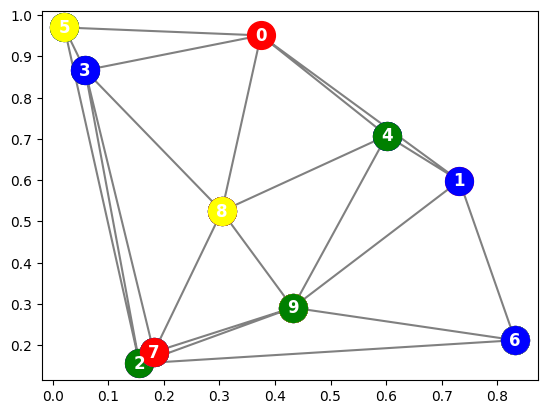

In [12]:
plt.triplot(points[:,0], points[:,1], tri.simplices, color = "gray")

for i in range(len(points)):
        plt.plot(points[i:,0], points[i:,1], 'o', color = list(assignment.values())[i], markersize = 20)
        plt.annotate(i, points[i,:],
        color='white', fontsize="large", weight='heavy',
        horizontalalignment='center', verticalalignment='center')

plt.show()

## Assignment

Implement the following graph coloring algorithms:

* Add variable and value ordering to the implementation.
* Add forward checking to the implementation.
* Implement hill climbing local search with the min-conflicts heuristic.

Try to color graphs of several sizes with 3 and 4 colors. For each $n$, generate several random instances, and try to make n as large as you can manage. On average, how many constraints (edges) do your map coloring instances have for each $n$? Report the performance of each search algorithm as a function of $n$. For both variants of backtracking search, you can characterize performance in terms of the number of variable assignments attempted. For hill climbing search, report the number of uphill moves and random restarts required in order to reach a solution. Of course, you can also report raw running times as a function of $n$.

In [13]:
# Graph Coloring CSP + Backtracking (MRV + Degree), LCV, Forward Checking
# + Hill-climbing (min-conflicts)
import numpy as np
import time
from collections import defaultdict, Counter

# ---------- Utility: build CSP from Delaunay triangulation ----------
def build_csp_from_points(points, tri, colors):
    """
    points: (n,2) numpy array
    tri: scipy.spatial.Delaunay object
    colors: list of color names (domain)
    returns: csp dict with keys 'variables', 'domains', 'constraints'
    constraints is a set of tuples (a,b) with a < b (strings)
    """
    n = len(points)
    variables = [str(i) for i in range(n)]
    domains = {v: list(colors) for v in variables}
    # collect edges from tri.simplices
    edges = set()
    for simplex in tri.simplices:
        simplex = list(simplex)
        for i in range(3):
            for j in range(i+1,3):
                a, b = sorted((str(simplex[i]), str(simplex[j])), key=lambda x:int(x))
                edges.add((a,b))
    constraints = set(edges)
    return {'variables': variables, 'domains': domains, 'constraints': constraints}

# ---------- Basic CSP helpers (complete, consistent) ----------
def complete(assignment, csp):
    return all(v in assignment for v in csp['variables'])

def consistent(assignment, csp):
    # check binary inequality constraints: neighbors cannot have same color
    for (a,b) in csp['constraints']:
        if a in assignment and b in assignment:
            if assignment[a] == assignment[b]:
                return False
    return True

# ---------- Neighbor helper ----------
def neighbors_of(var, csp):
    # return list of neighbor variable names (strings)
    v = var
    neigh = []
    for (a,b) in csp['constraints']:
        if a == v:
            neigh.append(b)
        elif b == v:
            neigh.append(a)
    return neigh

# ---------- Variable ordering: MRV (with degree tie-break) ----------
def select_unassigned_var(assignment, csp):
    if complete(assignment, csp):
        return None
    unassigned = [v for v in csp['variables'] if v not in assignment]
    # MRV: count remaining legal values in domain given current assignment
    best_vars = []
    best_count = None
    for var in unassigned:
        cnt = 0
        for val in csp['domains'][var]:
            assignment[var] = val
            if consistent(assignment, csp):
                cnt += 1
            del assignment[var]
        if best_count is None or cnt < best_count:
            best_count = cnt
            best_vars = [var]
        elif cnt == best_count:
            best_vars.append(var)
    # tie-break: choose variable with largest degree (most neighbors)
    if len(best_vars) == 1:
        return best_vars[0]
    else:
        degs = {v: len(neighbors_of(v, csp)) for v in best_vars}
        # choose var with max degree
        return max(best_vars, key=lambda x: degs[x])

# ---------- Value ordering: LCV (least-constraining) ----------
def order_domain_values(var, assignment, csp):
    values = list(csp['domains'][var])
    neighs = [n for n in neighbors_of(var, csp) if n not in assignment]
    # score: how many domain values of neighbors would be eliminated by choosing val
    scores = {}
    for val in values:
        elim = 0
        for n in neighs:
            # count how many values in domain of n would be disallowed (equal to val)
            elim += sum(1 for v in csp['domains'][n] if v == val)
        scores[val] = elim
    # least constraining: sort by ascending elim
    ordered = sorted(values, key=lambda x: scores[x])
    return ordered

# ---------- Forward checking (inference) ----------
def forward_check(var, value, assignment, csp, domains_backup=None):
    """
    Apply forward checking after assigning var=value.
    Returns:
      (True, pruned) if no domain emptied; pruned is dict var->list removed_vals
      (False, pruned) if some neighbor domain becomes empty --> failure
    This function DOES NOT permanently modify csp['domains'] unless you apply the prunings.
    We'll return pruned list so caller can update and restore.
    """
    pruned = defaultdict(list)
    for n in neighbors_of(var, csp):
        if n in assignment:
            continue
        # if value in domain of neighbor, it would be removed
        if value in csp['domains'][n]:
            pruned[n].append(value)
            # if removing leaves domain empty -> fail
            if len(csp['domains'][n]) - len(pruned[n]) <= 0:
                return False, pruned
    return True, pruned

def apply_pruned(pruned, csp):
    for var, removed in pruned.items():
        for v in removed:
            if v in csp['domains'][var]:
                csp['domains'][var].remove(v)

def restore_pruned(pruned, csp):
    for var, removed in pruned.items():
        # add back removed values (avoid duplicates)
        for v in removed:
            if v not in csp['domains'][var]:
                csp['domains'][var].append(v)

# ---------- Backtracking with MRV+Degree, LCV, Forward Checking ----------
VERBOSE = False
COUNT = 0

def backtrack_search(csp, use_forward_check=True):
    global COUNT
    COUNT = 0
    # make a shallow copy of domains so we can modify during search without changing original
    csp_local = {'variables': list(csp['variables']),
                 'domains': {v: list(csp['domains'][v]) for v in csp['variables']},
                 'constraints': set(csp['constraints'])}
    start = time.time()
    assignment = backtrack({}, csp_local, use_forward_check)
    elapsed = time.time() - start
    return assignment, COUNT, elapsed

def backtrack(assignment, csp, use_forward_check=True):
    global COUNT, VERBOSE
    COUNT += 1
    if complete(assignment, csp):
        return dict(assignment)
    var = select_unassigned_var(assignment, csp)
    if var is None:
        return dict(assignment)
    for val in order_domain_values(var, assignment, csp):
        assignment[var] = val
        if VERBOSE:
            print("Try", var, "=", val)
        if not consistent(assignment, csp):
            del assignment[var]
            continue
        pruned = {}
        failed = False
        if use_forward_check:
            ok, pruned = forward_check(var, val, assignment, csp)
            if not ok:
                failed = True
            else:
                # apply pruned to domains
                apply_pruned(pruned, csp)
        if not failed:
            result = backtrack(assignment, csp, use_forward_check)
            if result is not None:
                return result
        # restore pruned and undo assignment
        if use_forward_check and pruned:
            restore_pruned(pruned, csp)
        del assignment[var]
    return None

# ---------- Hill-climbing with min-conflicts ----------
def min_conflicts(csp, max_steps=100000, restart_limit=50, seed=None):
    """
    Returns solution assignment or None. Tracks statistics:
      - steps_taken: total steps (value changes)
      - restarts: number of random restarts performed
      - uphill_moves: moves that reduce conflicts? (we treat any change as a step)
    Implementation:
      - Random initial assignment
      - At each step pick a conflicted variable at random, assign it the color minimizing conflicts (tie break random)
      - If solution found return stats
      - After max_steps restart (count as restart)
    """
    rng = np.random.RandomState(seed)
    variables = csp['variables']
    domains = csp['domains']
    neighbors_map = {v: neighbors_of(v, csp) for v in variables}

    def conflicted_vars(assignment):
        conf = []
        for (a,b) in csp['constraints']:
            if assignment[a] == assignment[b]:
                conf.append(a)
                conf.append(b)
        return list(set(conf))

    def num_conflicts_for(var, val, assignment):
        cnt = 0
        for n in neighbors_map[var]:
            if assignment[n] == val:
                cnt += 1
        return cnt

    restarts = 0
    steps = 0
    uphill_moves = 0
    start_time = time.time()
    while restarts <= restart_limit:
        # random initial assignment
        assignment = {v: rng.choice(domains[v]) for v in variables}
        for step in range(max_steps):
            confl = conflicted_vars(assignment)
            if not confl:
                elapsed = time.time() - start_time
                return {'assignment': dict(assignment),
                        'steps': steps,
                        'restarts': restarts,
                        'elapsed': elapsed,
                        'uphill_moves': uphill_moves}
            var = rng.choice(confl)
            # choose value that minimizes conflicts (min-conflicts)
            vals = domains[var]
            conflicts_per_val = [num_conflicts_for(var, val, assignment) for val in vals]
            min_conf = min(conflicts_per_val)
            candidates = [vals[i] for i,c in enumerate(conflicts_per_val) if c == min_conf]
            new_val = rng.choice(candidates)
            # detect uphill: current conflicts for var vs new
            curr_conf = num_conflicts_for(var, assignment[var], assignment)
            if num_conflicts_for(var, new_val, assignment) >= curr_conf:
                uphill_moves += 1
            assignment[var] = new_val
            steps += 1
        # if reached here, do restart
        restarts += 1
    return None

# ---------- Experiment driver ----------
def run_experiment(instance_generator, colors, ns, trials=5, backtrack_fc=True, hill_max_steps=20000):
    """
    instance_generator(n) -> (points, tri, csp)
    ns: list of n values to test
    trials: number of random instances per n
    Returns aggregated stats dictionary
    """
    results = {'n': [], 'avg_edges': [],
               'backtrack_nodes': [], 'backtrack_time': [],
               'backtrack_nodes_no_fc': [], 'backtrack_time_no_fc': [],
               'hill_steps': [], 'hill_restarts': [], 'hill_time': []}
    for n in ns:
        edges_counts = []
        bt_nodes = []
        bt_time = []
        bt_nodes_nofc = []
        bt_time_nofc = []
        hill_steps = []
        hill_restarts = []
        hill_time = []
        for t in range(trials):
            points, tri, csp = instance_generator(n, colors)
            edges_counts.append(len(csp['constraints']))
            # backtracking with forward checking
            sol, nodes, elapsed = backtrack_search(csp, use_forward_check=backtrack_fc)
            bt_nodes.append(nodes)
            bt_time.append(elapsed)
            # backtracking without forward checking (for comparison)
            sol2, nodes2, elapsed2 = backtrack_search(csp, use_forward_check=False)
            bt_nodes_nofc.append(nodes2)
            bt_time_nofc.append(elapsed2)
            # hill-climbing
            hill = min_conflicts(csp, max_steps=hill_max_steps, restart_limit=50, seed=None)
            if hill is None:
                hill_steps.append(None)
                hill_restarts.append(None)
                hill_time.append(None)
            else:
                hill_steps.append(hill['steps'])
                hill_restarts.append(hill['restarts'])
                hill_time.append(hill['elapsed'])
        # aggregate means (ignore None in hill)
        results['n'].append(n)
        results['avg_edges'].append(np.mean(edges_counts))
        results['backtrack_nodes'].append(np.mean(bt_nodes))
        results['backtrack_time'].append(np.mean(bt_time))
        results['backtrack_nodes_no_fc'].append(np.mean(bt_nodes_nofc))
        results['backtrack_time_no_fc'].append(np.mean(bt_time_nofc))
        # hill stats with ignoring None values
        h_steps_clean = [x for x in hill_steps if x is not None]
        h_restarts_clean = [x for x in hill_restarts if x is not None]
        h_time_clean = [x for x in hill_time if x is not None]
        results['hill_steps'].append(np.mean(h_steps_clean) if h_steps_clean else None)
        results['hill_restarts'].append(np.mean(h_restarts_clean) if h_restarts_clean else None)
        results['hill_time'].append(np.mean(h_time_clean) if h_time_clean else None)
    return results

# ---------- Example instance generator using Delaunay ----------
def instance_from_delaunay(n, colors, seed=None):
    from scipy.spatial import Delaunay
    rng = np.random.RandomState(seed)
    pts = rng.randint(0, 1000, size=(n,2))
    # optional: sort by x for nicer triangulation (as you did)
    o = np.argsort(pts[:,0])
    pts = pts[o,:]
    tri = Delaunay(pts)
    csp = build_csp_from_points(pts, tri, colors)
    return pts, tri, csp




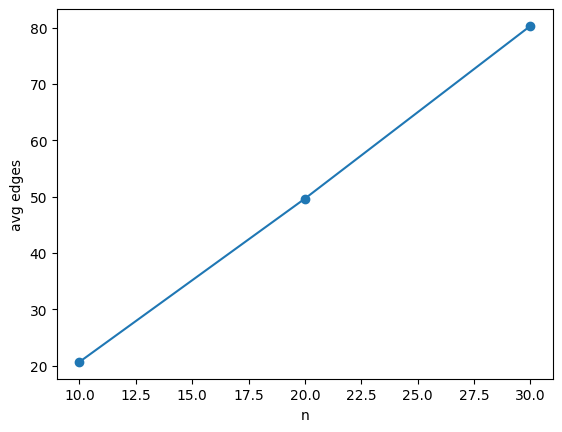

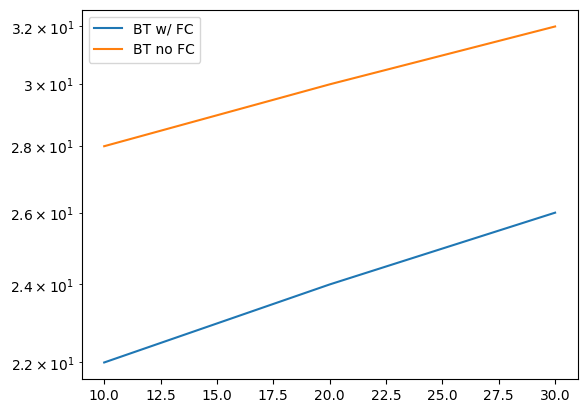

In [14]:
import matplotlib.pyplot as plt
res = run_experiment(instance_from_delaunay, ['red','blue','green'], ns=[10,20,30], trials=3)
plt.plot(res['n'], res['avg_edges'], marker='o'); plt.xlabel('n'); plt.ylabel('avg edges'); plt.show()
plt.plot(res['n'], res['backtrack_nodes'], label='BT w/ FC');
plt.plot(res['n'], res['backtrack_nodes_no_fc'], label='BT no FC');
plt.yscale('log'); plt.legend(); plt.show()
